In [1]:
# import a few packages for the project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#packages for selection model features 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#packages for model training
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

#additional/service packages for model training
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [2]:
# switch off some warning messages
pd.options.mode.chained_assignment = None

In [3]:
url = 'https://raw.githubusercontent.com/user121989/house-prices-prediction-project-Kaggle-/master/train.csv'
data = pd.read_csv(url, index_col='Id')

# Exploratory Data Analysis (EDA)
Let's start with EDA to understand what data  we have

### 1. Find and drop columns with a lot of missing data

The 0.25 threshold was chosen here, in other words columns that contained more than 25% missing data were dropped.
To handle this problem a special function "cleaning_algorithm" was written.

In [4]:
#function to compute null spaces in the columns and delete a column which is not satisfied conditions
def cleaning_algorithm(df, percent=0.25):
    def checking_amount_of_null_per_column ():
        list_suspected = pd.Series(df.columns.to_list())
        trouble_list = []
        trouble_score = []
        for i in list_suspected:
            amount_of_na = df[i].isna().sum()
            count_percentages_of_na = amount_of_na/len(df.index)
            if count_percentages_of_na >= percent:
                trouble_list.append(i)
                trouble_score.append(count_percentages_of_na)
        return pd.Series(trouble_list, trouble_score)
    print('initial amount of columns: ', len(df.columns))
    print('\n')
    a = checking_amount_of_null_per_column()
    a = pd.DataFrame({'column_name':a.values, '% of null values':a.index})
    df = df.drop(list(a['column_name']), axis=1)
    print('list of columns were dropped:', a, sep='\n')
    print('\n')
    print('amount of columns after cleaning: ', len(df.columns))
    return df

In [5]:
data = cleaning_algorithm(data)

initial amount of columns:  80


list of columns were dropped:
   column_name  % of null values
0        Alley          0.937671
1  FireplaceQu          0.472603
2       PoolQC          0.995205
3        Fence          0.807534
4  MiscFeature          0.963014


amount of columns after cleaning:  75


### 2. Separate initial data into two dataframes: numerical and categorical

Since categorical data and numerical data should be treated differently initial base was separated into the two dataframes: data_categorical and data_numeric. Let's start with the first one.

### 2.1 Categorical data frame

In [6]:
data['MSSubClass'] = data['MSSubClass'].astype('category')

In [7]:
data_categorical = data.select_dtypes(include=['object', 'category'])

In [8]:
data_categorical.loc[:,'CentralAir'] = data_categorical.CentralAir.map({'Y':1, 'N':0})

In [9]:
data_categorical = data_categorical.astype('category')

####   ================================  Decoding attitude measure data into numeric. Beginning   ================================

In [10]:
recoding = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']

In [11]:
# decoding letters to numbers
data_categorical.loc[:,recoding] = data_categorical.loc[:,recoding].apply(lambda x: x.map({'TA':3, 'Gd':4, 'Fa':2, 'Po':1, 'Ex':5}))

In [12]:
# fill na with the most common value in a column
data_categorical.loc[:,recoding] = data_categorical.loc[:,recoding].apply(lambda x:x.fillna(x.value_counts().index[0]))

In [13]:
# change type of data to numeric
data_categorical.loc[:,recoding] = data_categorical.loc[:,recoding].apply(lambda x: x.astype('int64'))

In [14]:
# drop columns from the categorical set and add it to the full base
data[recoding] = data_categorical[recoding]
data_categorical = data_categorical.drop(recoding, axis=1)

#### ================================  Decoding attitude measure data into numeric. End  ================================

In [15]:
#and the last one - get dummies features
data_categorical = pd.get_dummies(data_categorical, columns=data_categorical.columns)

### 2.2 NUMERIC

In [16]:
data_numeric = data.select_dtypes(include=['int64','float64'])

In [17]:
#let's watch what we have
data_numeric.describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
ExterQual,1460.0,3.395890,0.574280,2.0,3.00,3.0,4.00,5.0
ExterCond,1460.0,3.083562,0.351054,1.0,3.00,3.0,3.00,5.0
BsmtQual,1460.0,3.565068,0.678071,2.0,3.00,4.0,4.00,5.0


In [18]:
# fill na cases with mean
def fill_with_mean (df):
    list_suspected = pd.Series(df.columns.to_list())
    amount_of_na=[]
    for i in list_suspected:
        amount_of_na = df[i].isna().sum()
        if amount_of_na >0:
            df[i].fillna(value=df[i].mean(), inplace=True)
    return df

In [19]:
fill_with_mean(data_numeric)
# miss values were cured
data_numeric.describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1460.0,70.049958,22.024023,21.0,60.00,70.049958,79.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.500000,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.000000,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.000000,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.000000,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.000000,2004.00,2010.0
MasVnrArea,1460.0,103.685262,180.569112,0.0,0.00,0.000000,164.25,1600.0
ExterQual,1460.0,3.395890,0.574280,2.0,3.00,3.000000,4.00,5.0
ExterCond,1460.0,3.083562,0.351054,1.0,3.00,3.000000,3.00,5.0
BsmtQual,1460.0,3.565068,0.678071,2.0,3.00,4.000000,4.00,5.0


### 2.2.1 Clearning outliers
There are a lot of numeric data and it's natural to check whether outliers occur in the data set.

#### Visual checking
Let's start with the visual checking. Boxplot is the most handy tool for visual outliers checking.

But not all data is suitable for checking outliers. It's necessary to create ban list where features that is not appropriate for this task will be hold.

In [20]:
ban_list = ['BsmtFinSF2','LowQualFinSF','BsmtFullBath','BsmtHalfBath','HalfBath','Fireplaces','EnclosedPorch','3SsnPorch','ScreenPorch',
'PoolArea','MiscVal','Month', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'OverallCond', 'YearBuilt', 'YrSold'
 'YearRemodAdd', 'GarageQual', 'GarageCond', 'Year', 'Day', 'OverallQual', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt','GarageCars']

In [21]:
def cool_plots(data, col):
    plt.figure(figsize=(15, 10))
    plt.subplot(2,2,1)
    sns.boxplot(data_numeric[col])
    plt.title('Box plot of {}'.format(col), fontsize=20)
    plt.xlabel(col)
    plt.subplot(2,2,2)
    sns.distplot(data_numeric[col])
    plt.title('{} distribution'.format(col), fontsize=20)
    plt.xlabel(col)
    plt.ylabel('% of all')
    plt.subplots_adjust(bottom=0.25, top=0.75)
    plt.show()

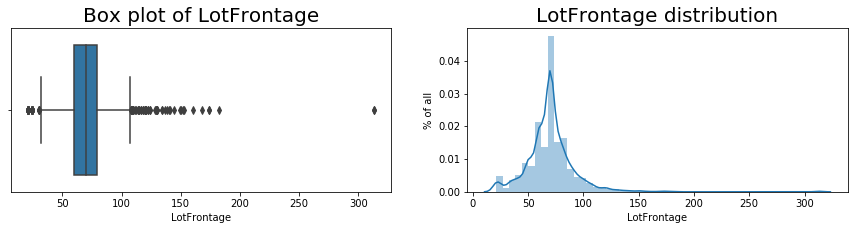

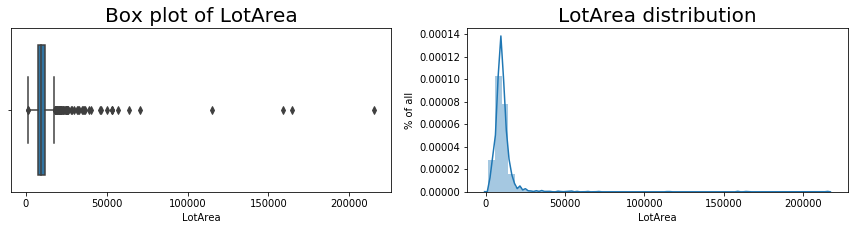

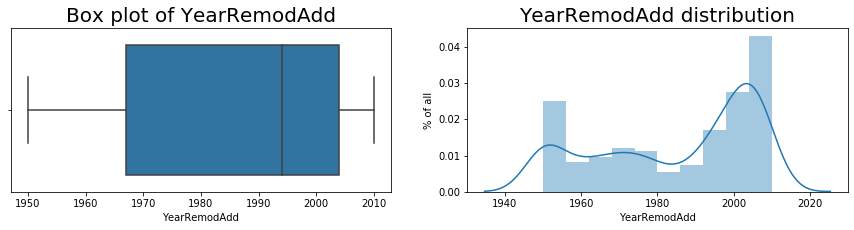

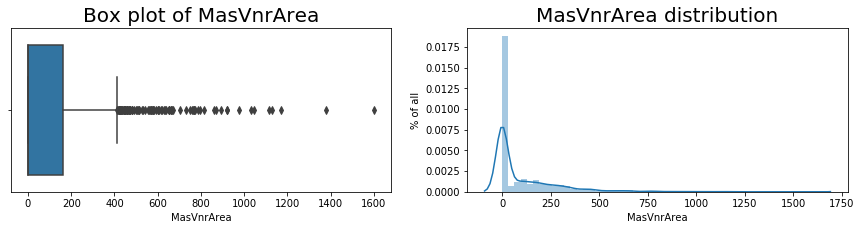

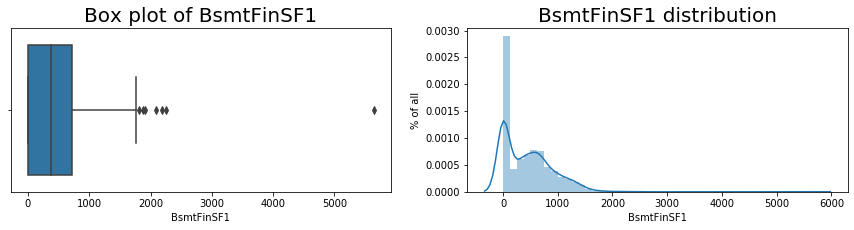

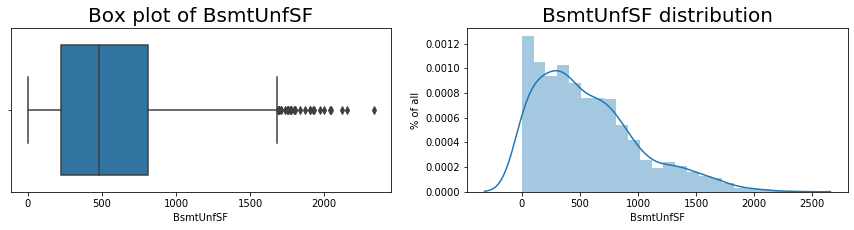

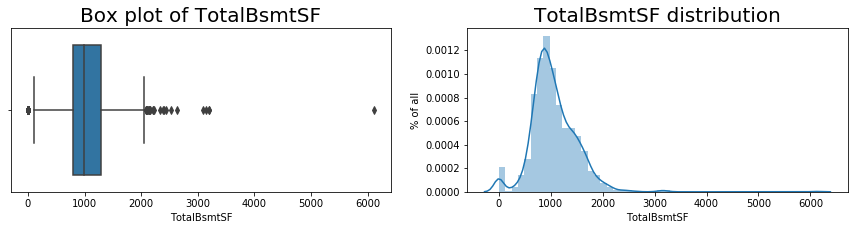

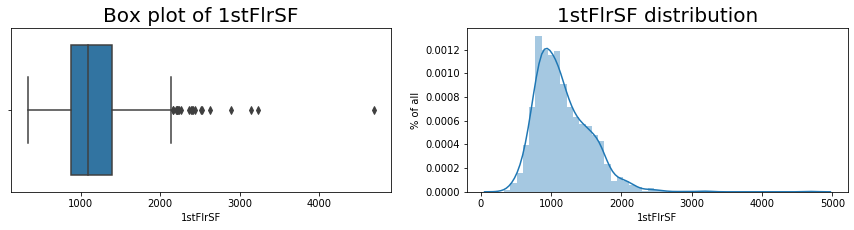

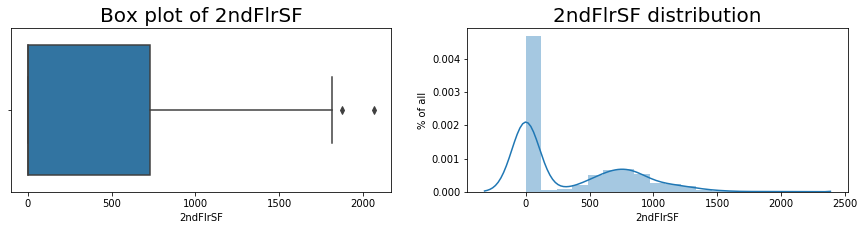

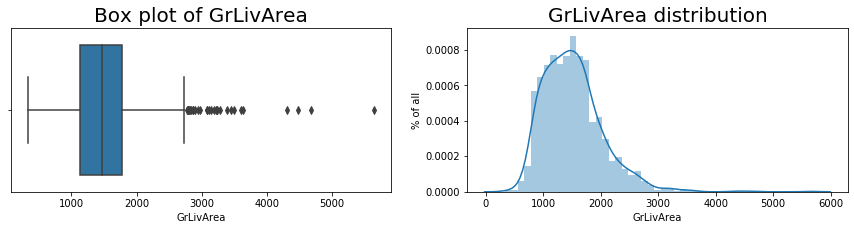

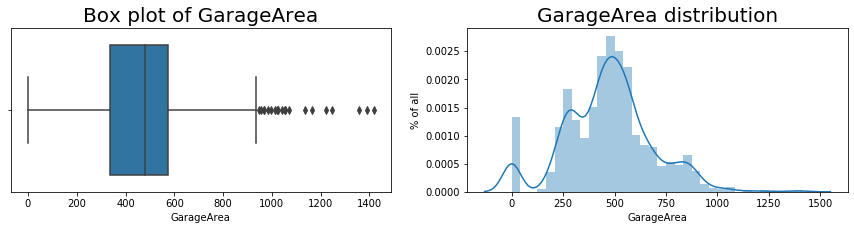

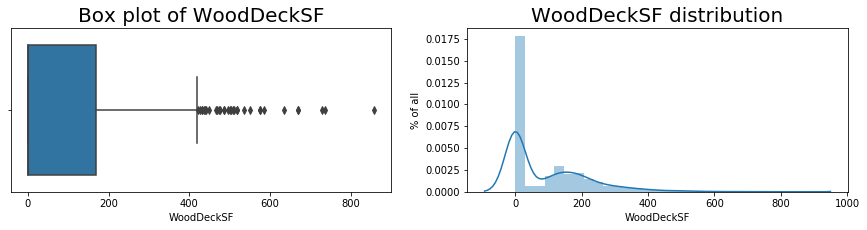

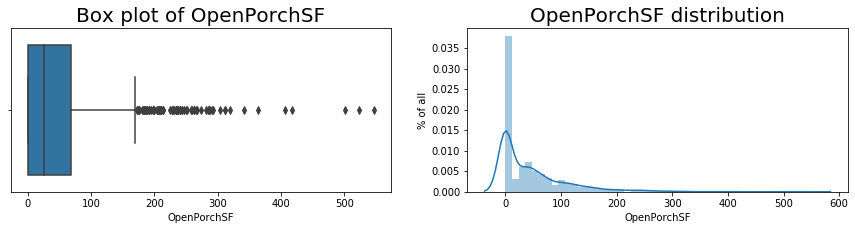

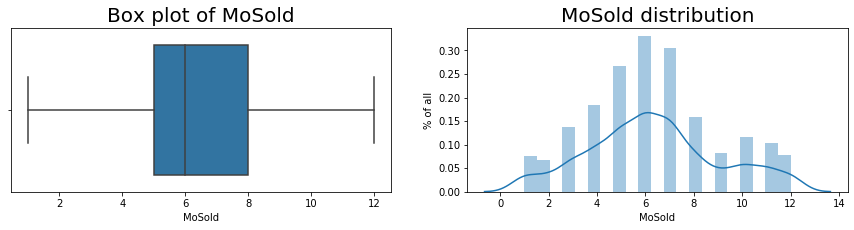

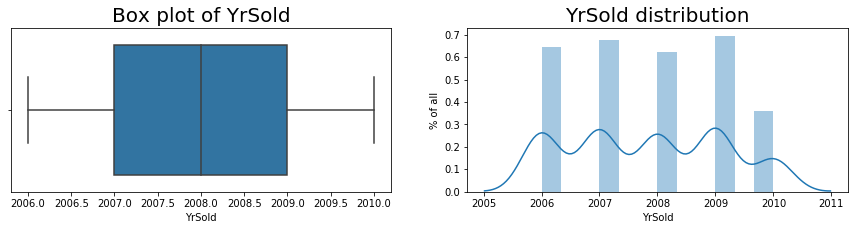

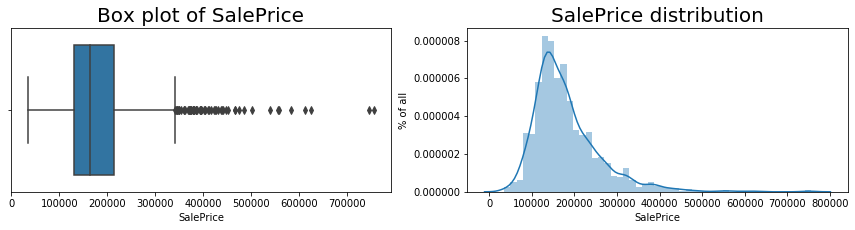

In [22]:
for col in data_numeric.columns:
    if col not in ban_list:
        cool_plots(data_numeric, col)

#### Z-score outliers detection
There a lot of outliers. Thus,  we need a relevant algorithm that is able to detect outliers in the each variable. For this purpose z_score_cleaning_all algorithm was written.

The function requests 2 parametrs: a data set name (df) and ban list (ban_l). As above, ban list includes names of the featureas that are not suitable for z-score analysis.

In [23]:
def z_score_cleaning_all(df, ban_l=[]):
    outliers = []
    list_of_outliers = []
    
    
    for col in range(len(df.columns)):
        std = df.iloc[:,col].std()
        mean = df.iloc[:,col].mean()
        if df.columns[col] not in ban_l:
            for i in range(df.shape[0]):
                if abs((df.iloc[i,col]-mean))/std>3:
                    list_of_outliers.append(i)
            
#return unique values only            
            uniq_l = []
            for i in list_of_outliers:
                if i not in uniq_l:
                    uniq_l.append(i+1)
        
#buble sort
            for i in range(len(uniq_l)):
                for j in range(len(uniq_l)-1):
                    if uniq_l[j] > uniq_l[j+1]:
                        uniq_l[j], uniq_l[j+1] =  uniq_l[j+1], uniq_l[j]

    print('amount of rows with outliers to drop:', len(uniq_l))
    return uniq_l

In [24]:
# list with detected outliers
list_out = z_score_cleaning_all(data_numeric, ban_list)

amount of rows with outliers to drop: 192


In [25]:
# dropping outliers
data_numeric = data_numeric.drop(list_out)

### 2.2.2. Checking logic of the numeric data

The data contains information about different parameters of area. This is logical to check whether lot area always bigger than other parameters.

In [26]:
# creating list with necessary data
def checking_area_list(data):
    list_for_checking = []
    
    bench_list = ["SF", "Area", "Enclosed"]
    for i in data.columns:
        for bench in bench_list:
            if bench in i:
                list_for_checking.append(i)
    #delete the first column, because it's a benchmark value            
    return list_for_checking[1:]

In [27]:
list_area_check=checking_area_list(data_numeric)

In [28]:
def check_ar(data, bench, list_to_check):
    for i in list_to_check:
        data[bench+' '+i] = np.where(data[bench] < data[i], 'True', 'False')
    return data

In [29]:
expended_data = check_ar(data_numeric, 'LotArea', list_area_check)

In [30]:
st = []
count_right_samples = []
for i in expended_data.iloc[:,-14:].columns:
    st = list(expended_data.loc[:,i])
    count_right_samples.append(len(np.where(st)[0]))

In [31]:
count_right_samples == [data_numeric.shape[0]]*14

True

In [32]:
data_numeric = data_numeric.drop(data_numeric.columns[-14:], axis=1)

Thus, there is no an area that is bigger than lot area.

### 1.3 Merging 2 DFs
Now it's necessary to merge categorical and numerical data sets into the one dataframe.

In [33]:
merged_data = pd.merge(data_numeric, data_categorical, how='left', left_index=True, right_index=True)

In [34]:
merged_data = merged_data.dropna()

In [35]:
merged_data = merged_data.reset_index(drop=True)

In [36]:
merged_data = pd.get_dummies(merged_data, columns=data_categorical.columns)

In [37]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Columns: 466 entries, LotFrontage to SaleCondition_Partial_1
dtypes: float64(3), int64(41), uint8(422)
memory usage: 1013.7 KB


### 1.4 Check importance of the variables

Data frame includes 466 columns now, but not all of them deliver important contribution to the prediction model. Thus, it's logical to check importance of the features in the data frame and drop not useful variables.

In [38]:
X_train = merged_data.loc[1:].drop('SalePrice', axis=1)
y_train = merged_data.loc[1:].SalePrice

Here it's logical to implement SelectKBest algorithm with chi2 that can return required number of features. Say it will be 19 features - this number was chosen by empirical testing of a few numbers.

In [39]:
#Let's create a new df with the k-highest rang
X_new = SelectKBest(chi2, k=19).fit_transform(X_train, y_train)
X_new.shape

(1340, 19)

But for the further work with test samples it's important to know which columns were chosen. Let's implement code below to understand that.

In [40]:
# Create and fit selector
selector = SelectKBest(chi2, k=19)
selector.fit(X_train, y_train)
# Get columns to keep and create new dataframe with those only
colums_to_keep = selector.get_support(indices=True)

In [41]:
merged_data.iloc[:,colums_to_keep].columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

Before we start building models, let's check what the ranking of the importance of variables will be generated by the Random Forest algorithm.

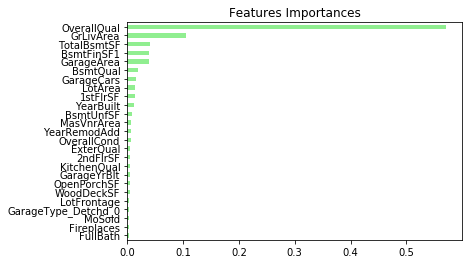

In [42]:
### CHECKING IMPORTANT FEATURES

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,
            random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train, y_train) 

# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()
importances_sorted = importances_sorted

# Draw a horizontal barplot of importances_sorted
importances_sorted.tail(25).plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()# Create a pd.Series of features importances

Let's append 'OverallQual' variable to the current list of the selected features.

In [43]:
colums_to_keep = np.append(colums_to_keep, merged_data.drop('SalePrice', axis=1).columns.get_loc('OverallQual'))

In [44]:
important_cols = merged_data.drop('SalePrice', axis=1).iloc[:,colums_to_keep].columns

In [45]:
X_new_1=merged_data[important_cols]
X_new_1 = X_new_1[1:]
X_new_1.shape

(1340, 20)

# Build a prediction model

Let's start with the simplest one - linear regression model

In [46]:
### Linear regression ###

Linear_reg = linear_model.LinearRegression()

LR_scores = cross_val_score(
        Linear_reg, X_new_1, y_train,
        cv=5)

LR_scores.mean()


0.8260732760918252

Not bad, but let's check more sophisticated models.

In [47]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsRegressor())]

pipeline_knn = Pipeline(steps)



# Setup the hyperparameter grid
param_grid = {'knn__n_neighbors': np.array(range(1,20))}

# Instantiate the GridSearchCV object: knn_cv
knn_cv = GridSearchCV(pipeline_knn, param_grid, cv=5)

# Fit it to the data
knn_cv.fit(X_new_1, y_train)  ######Better  use training data, not whole data

# Print the tuned parameters and score
print("Tuned KNN Parameters: {}".format(knn_cv.best_params_)) 
print("Best score is {}".format(knn_cv.best_score_))

Tuned KNN Parameters: {'knn__n_neighbors': 16}
Best score is 0.778310301783671


In [48]:
# Setup the parameters and distributions to sample from: param_dist - _just a list of parametrs to check_
param_dist = {"max_depth": [3, None],
              "max_features": np.array(range(1,7)),
              "min_samples_leaf": np.array(range(1,7))}

# Instantiate a Decision Tree Regressor: tree
tree = DecisionTreeRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data

tree_cv.fit(X_new_1,y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': None, 'max_features': 6, 'min_samples_leaf': 4}
Best score is 0.7400599826176506


In [49]:
### Define the dictionary 'params_rf'
params_rf = {
    'n_estimators':[int(x) for x in np.linspace(start = 100, stop = 500, num = 4)],
    'max_features':['log2','auto','sqrt'],
    'max_depth' : np.array(range(1,7)),
    'min_samples_leaf':[int(x) for x in np.linspace(start = 1, stop = 10, num = 4)]}



### Setup a model
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor()

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       cv=3)

grid_rf.fit(X_new_1, y_train)


print("Tuned Decision RF: {}".format(grid_rf.best_params_))
print("Best score is {}".format(grid_rf.best_score_))

Tuned Decision RF: {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 233}
Best score is 0.8407594646520858


In [50]:
### Set up AdaBoostRegressor



# Parametrs for griding
param_grid = {
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }


# Instantiate dt
dt = DecisionTreeRegressor(max_depth= None, max_features=5, min_samples_leaf=6)

# Instantiate ada
ada = AdaBoostRegressor(base_estimator=dt)


grid_ada = GridSearchCV(estimator=ada,
                       param_grid=param_grid,
                       cv=3)

### Fitting the model and predicting probability of their decisions
# Fit ada to the training set
grid_ada.fit(X_new_1, y_train)



# Compute and print metrics
print("Tuned AdaBoostRegressor Parameters: {}".format(grid_ada.best_params_))
print("Best score is {}".format(grid_ada.best_score_))

Tuned AdaBoostRegressor Parameters: {'base_estimator__splitter': 'best', 'n_estimators': 1}
Best score is 0.6477658558168249


In [51]:
### Set up Xgb

xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_new_1,
         y_train)

print("Tuned XGBRegressor Parameters: {}".format(xgb_grid.best_params_))
print("Best score is {}".format(xgb_grid.best_score_))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   19.7s finished


[22:25:21] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[22:25:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:25:22] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
Tuned XGBRegressor Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
Best score is 0.8469951974864008


# Compare results
Now it's possible to compare how accurate models were

In [52]:
models_score = ({
    'AdaBoost' : grid_ada.best_score_,
    'Linear Regression' : LR_scores.mean(),
'Random Forest' : grid_rf.best_score_,
'Desicion tree': tree_cv.best_score_,
'KNN': knn_cv.best_score_,
'Xgboost': xgb_grid.best_score_})
models_score = pd.Series(models_score).to_frame('Model_score')
models_score = pd.DataFrame(models_score).reset_index()
models_score.rename(columns={'index':'Model_name'}, inplace=True)
models_score.sort_values(by='Model_score', inplace=True, ascending=False)

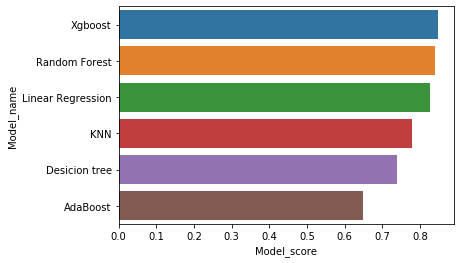

In [53]:
sns.barplot(x='Model_score',y='Model_name', data=models_score)
plt.show()

The winner is the Xgboost algorithm, let's implement it to the test data set.

# Prediction

In [54]:
url_test = 'https://raw.githubusercontent.com/user121989/house-prices-prediction-project-Kaggle-/master/test.csv'
data_test = pd.read_csv(url_test, index_col='Id')

In [55]:
X_test = data_test.loc[1:,important_cols]

In [56]:
xgb_grid.predict(X_test)

array([139035.92 , 168445.4  , 179912.08 , ..., 183033.9  , 108256.336,
       243500.75 ], dtype=float32)

In [57]:
prediction_xgb = xgb_grid.predict(X_test)
xgb_prediction = pd.Series(prediction_xgb, index= list(range(1461,2920))).to_frame('SalePrice')
xgb_prediction.index.name= 'Id'

Final result - 0.16004 Root Mean Squared Logarithmic error.
A lot of space for the further improvement.